In [2]:
from functools import partial

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf
import keras

from priors import rdm_prior_simple
from design import random_num_obs_discrete
from simulation import rdm_experiment_simple, CustomSimulator, batch_simulator

from bayesflow.utils import batched_call, tree_stack

import jax

from pymc_models import rdm_model_simple, RdmSimple

In [3]:
rng = np.random.default_rng()

In [4]:
prior_fun = partial(rdm_prior_simple, drift_intercept_loc=2,
    drift_intercept_scale=1,
    drift_slope_loc=2,
    drift_slope_scale=1,
    sd_true_shape=10,
    sd_true_scale=0.2,
    threshold_shape=10,
    threshold_scale=0.2,
    t0_loc=0.2,
    t0_scale=0.1,
    t0_lower=0,
    rng=rng)

In [5]:
num_obs_fun = partial(random_num_obs_discrete, values=[500], rng=rng)

In [6]:
simulator = CustomSimulator(
    prior_fun=prior_fun,
    design_fun=num_obs_fun,
    simulator_fun=partial(batch_simulator, simulator_fun=partial(rdm_experiment_simple, s_false=1, rng=rng)),
)

In [7]:
sample_data = simulator.sample((10,))

In [8]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['v_intercept', 'v_slope', 's_true', 'b', 't0', 'num_obs', 'x'])
Types of sample_data values:
	 {'v_intercept': <class 'numpy.ndarray'>, 'v_slope': <class 'numpy.ndarray'>, 's_true': <class 'numpy.ndarray'>, 'b': <class 'numpy.ndarray'>, 't0': <class 'numpy.ndarray'>, 'num_obs': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'v_intercept': (10, 1), 'v_slope': (10, 1), 's_true': (10, 1), 'b': (10, 1), 't0': (10, 1), 'num_obs': (10, 1), 'x': (10, 500, 2)}


In [9]:
class LogTransform(bf.adapters.transforms.ElementwiseTransform):
    def forward(self, data, **kwargs):
        return np.log(data)
    

    def inverse(self, data, **kwargs):
        return np.exp(data)

In [10]:
class Broadcast(bf.adapters.transforms.Transform):
    def __init__(self, keys, *, to: str, expand: str | int | tuple = "left", exclude: int | tuple = -1):
        super().__init__()
        self.keys = keys
        self.to = to

        if isinstance(expand, int):
            expand = (expand,)

        self.expand = expand

        if isinstance(exclude, int):
            exclude = (exclude,)

        self.exclude = exclude


    def forward(self, data, strict=True, **kwargs):
        if strict:
            target_shape = data[self.to].shape

            data = data.copy()

            for k in self.keys:
                # ensure that .shape is defined
                data[k] = np.asarray(data[k])
                len_diff = len(target_shape) - len(data[k].shape)

                if self.expand == "left":
                    data[k] = np.expand_dims(data[k], axis=tuple(np.arange(0, len_diff)))
                elif self.expand == "right":
                    data[k] = np.expand_dims(data[k], axis=tuple(-np.arange(1, len_diff + 1)))
                elif isinstance(self.expand, tuple):
                    if len(self.expand) is not len_diff:
                        raise ValueError("Length of `expand` must match the length difference of the involed arrays.")
                    data[k] = np.expand_dims(data[k], axis=self.expand)

                new_shape = target_shape
                if self.exclude is not None:
                    new_shape = np.array(new_shape, dtype=int)
                    old_shape = np.array(data[k].shape, dtype=int)
                    exclude = list(self.exclude)
                    new_shape[exclude] = old_shape[exclude]
                    new_shape = tuple(new_shape)

                data[k] = np.broadcast_to(data[k], new_shape)

        return data
    

    def inverse(self, data: dict[str, np.ndarray], **kwargs) -> dict[str, np.ndarray]:
        return data

In [11]:
inference_variables = ["x"]
inference_conditions = ["v_intercept", "v_slope", "s_true", "b", "t0"]

adapter = (bf.adapters.Adapter()
    # .to_array()
    # .convert_dtype("float64", "float32")
    .drop("num_obs")
    .concatenate(inference_variables, into="inference_variables")
    .concatenate(inference_conditions, into="inference_conditions")
    # .add_transform(bf.adapters.transforms.FilterTransform(transform_constructor=LogTransform, include="inference_conditions"))
    # .standardize()
    # .expand_dims("inference_conditions", axis=1)
    # .add_transform(Broadcast(keys=["inference_conditions"], to="inference_variables", expand=1))
    .broadcast("inference_conditions", to="inference_variables", expand=1)
)

In [12]:
# inference_network = bf.networks.FlowMatching(
#     subnet="mlp",
#     subnet_kwargs=dict(
#         widths=[256] * 3,
#         dropout=0.0,
#     ),
#     use_optimal_transport=False,
# )
inference_network = bf.networks.CouplingFlow()

In [13]:
approximator = bf.ContinuousApproximator(
    # summary_network=summary_network,
    inference_network=inference_network,
    adapter=adapter,
)

In [14]:
epochs = 5
num_batches = 500
batch_size = 64

In [15]:
initial_learning_rate = 0.001
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=num_batches*epochs,
    alpha=1e-8
)

optimizer = keras.optimizers.AdamW(learning_rate=scheduled_lr)

In [16]:
approximator.compile(optimizer)

In [17]:
history = approximator.fit(
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    # memory_budget="8 GiB",
    simulator=simulator
)

INFO:bayesflow:Building dataset from simulator instance of CustomSimulator.
INFO:bayesflow:Using 32 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: -0.2369 - loss/inference_loss: -0.2369
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: -1.6572 - loss/inference_loss: -1.6572
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: -2.8949 - loss/inference_loss: -2.8949
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: -4.1672 - loss/inference_loss: -4.1672
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: -5.1500 - loss/inference_loss: -5.1500


In [334]:
test_data = simulator.sample((10,))
# del test_data["x"]

In [335]:
test_prior = np.log(np.moveaxis([val for key, val in test_data.items() if key in inference_conditions], [0, 1, 2], [2, 0, 1]))

In [336]:
sample_dict = {k: v for k, v in test_data.items() if k not in inference_variables}

In [337]:
# posterior_samples = approximator.sample(conditions=sample_dict, num_samples=100)

In [338]:
ll_nle = approximator.log_prob(test_data)

In [344]:
def get_ll(approximator, data):
    data = keras.tree.map_structure(keras.ops.convert_to_tensor, adapter(data, strict=True, stage="inference"))
    z = approximator.inference_network._forward(data["inference_variables"], data["inference_conditions"])
    return approximator.inference_network.base_distribution.log_prob(z)

In [345]:
ll_nle = get_ll(approximator, test_data)

In [44]:
ll_fun_vec = np.vectorize(rdm_model_simple, signature="(m,n)->()")

In [45]:
def logp_fun(x, theta):
    rt_true = x[x[:, 1] == 1, 0]
    rt_false = x[x[:, 1] == 0, 0]

    ll_true = RdmSimple.logp(rt_true, drift_winner=theta[0]+theta[1], drift_loser=theta[0], s_winner=theta[2], s_loser=1, threshold=theta[3], ndt=theta[4]).eval()
    ll_false = RdmSimple.logp(rt_false, drift_winner=theta[0], drift_loser=theta[0]+theta[1], s_winner=1, s_loser=theta[2], threshold=theta[3], ndt=theta[4]).eval()

    return np.sum(ll_true) + np.sum(ll_false)

In [46]:
logp_fun(test_data["x"][0,:,:], np.moveaxis([val for key, val in test_data.items() if key in inference_conditions], [0, 1, 2], [2, 0, 1])[0,0,:])

204.89790578845884

In [48]:
test_forward_dict = adapter.forward(test_data)

In [339]:
ll_fun_batch = ll_fun_vec(test_data["x"])

In [340]:
ll_ref = np.array([fun(theta) for fun, theta in zip(ll_fun_batch, test_prior.squeeze())])

In [348]:
ll_nle.sum(axis=1)-ll_ref

Array([-1047.34589387, -1225.87521977, -1343.89098539, -1930.67324177,
       -1197.68983555, -1305.59857068, -1381.54191765, -1213.73699876,
       -1047.85854516, -1670.47130053], dtype=float64)

In [347]:
np.corrcoef(ll_ref, ll_nle.sum(axis=1))

array([[1.       , 0.7963936],
       [0.7963936, 1.       ]])

Text(0, 0.5, 'NLE likelihood')

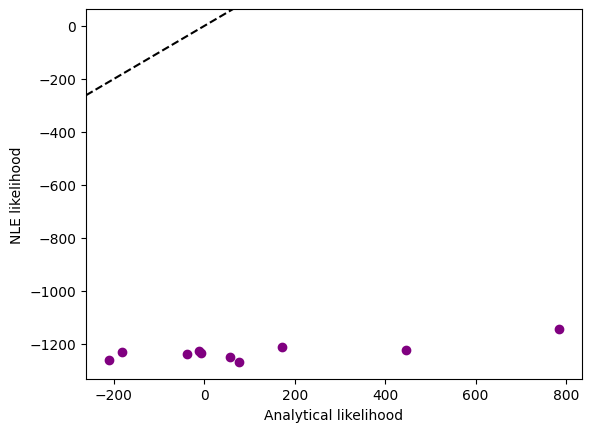

In [346]:
fig, ax = plt.subplots(1, 1)

ax.scatter(ll_ref, ll_nle.sum(axis=1), color="purple")
ax.axline([0, 0], slope=1, linestyle="--", color="black")
# ax.set_ylim((-1000, 3000))
ax.set_xlabel("Analytical likelihood")
ax.set_ylabel("NLE likelihood")

In [110]:
show_data = simulator.sample((1,), num_obs=10000)

In [123]:
show_prior = np.log(np.moveaxis([val for key, val in show_data.items() if key in inference_conditions], [0, 1, 2], [2, 0, 1]))

In [111]:
ll_nle_show = approximator.log_prob(show_data).squeeze()

In [113]:
rt = show_data["x"].squeeze()

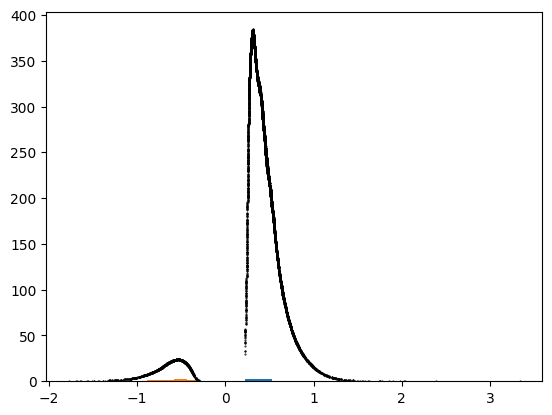

In [142]:
fig, ax = plt.subplots(1, 1)

ax.hist(rt[rt[:, 1] == 1, 0], density=True)
ax.hist(-rt[rt[:, 1] == 0, 0], density=True)

ax.scatter(rt[rt[:, 1] == 1, 0], np.exp(ll_nle_show[rt[:, 1] == 1]), color="black", s = 0.2)
ax.scatter(-rt[rt[:, 1] == 0, 0], np.exp(ll_nle_show[rt[:, 1] == 0]), color="black", s = 0.2)

In [18]:
from pymc_models import run_mcmc

import blackjax
import jax.numpy as jnp

In [19]:
test_data = simulator.sample((1,))
data = keras.tree.map_structure(keras.ops.convert_to_tensor, adapter(test_data, strict=True, stage="inference"))
data["inference_conditions"].shape

(1, 500, 5)

In [20]:
@jax.jit
def logdensity_fun(x):
    data["inference_conditions"] = jnp.tile(x, (1, 500, 1))

    return jnp.sum(approximator._log_prob(**data))

In [25]:
logdensity_fun(np.array([2, 2, 1, 2, 0.2]))

Array(1247.1149, dtype=float32)

In [34]:
trace = run_mcmc(logdensity_fun, blackjax.nuts, init_position=np.exp([2, 2, 1, 2, 0.2]), num_chains=1, num_steps_warmup=1000, num_steps_sampling=1000)

In [ ]:
import arviz

In [37]:
trace[0].position.shape

(1, 1000, 5)

In [41]:
[v for k, v in test_data.items() if k in inference_conditions]

[array([[1.66333716]]),
 array([[1.71334016]]),
 array([[1.86855384]]),
 array([[2.92700182]]),
 array([[0.25831389]])]

TypeError: scatter() missing 1 required positional argument: 'y'

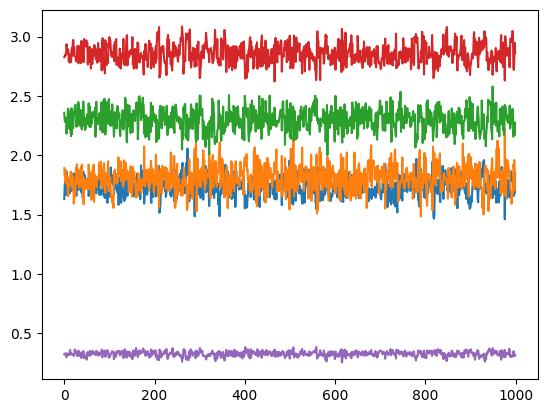

In [48]:
plt.plot(trace[0].position[0,:,:])
# plt.scatter(np.array([[i, v.squeeze()] for i, (k, v) in enumerate(test_data.items()) if k in inference_conditions]))
# plt.legend()